# Name : Paavani Ramakrishna
# Git Username: paavani2000
# USC ID: 7696462483

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Example: Download to Google Drive directly
# !wget -O "/content/drive/My Drive/Data/RealWaste.zip" "https://www.dropbox.com/scl/fo/hkszyb94vqwvvmo9cvxxs/AC2hEJs-emerHNzw_fZE100/RealWaste?rlkey=y4f8atxry7rqas9hv6kr7qc91&subfolder_nav_tracking=1&dl=1"

# # Unzip it in Drive to save Colab RAM
# !unzip "/content/drive/My Drive/Data/RealWaste.zip" -d "/content/drive/My Drive/Data/RealWaste"


In [2]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
import cv2
from google.colab import drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Now directly access the dataset
data_dir = '/content/drive/My Drive/Data/RealWaste'
classes = sorted(os.listdir(data_dir))
num_classes = len(classes)
image_size = (224, 224)  # Standard size for the pre-trained models
validation_split = 0.2   # 20% for validation as specified

print(f"Found {num_classes} waste categories: {classes}")

Mounted at /content/drive
Found 9 waste categories: ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']


Pre-processing

In [20]:
train_paths = []
train_labels = []
val_paths = []
val_labels = []
test_paths = []
test_labels = []

# Process images and create train/val/test splits
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    image_files = sorted([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    # Calculate split indices
    train_end = int(len(image_files) * 0.8)  # First 80% for training/validation

    # Split the train portion for training (80%) and validation (20% of training)
    train_val_files = image_files[:train_end]
    val_idx = int(len(train_val_files) * 0.8)

    # Assign to respective sets
    for i, img_file in enumerate(train_val_files):
        img_path = os.path.join(class_dir, img_file)
        if i < val_idx:
            train_paths.append(img_path)
            train_labels.append(class_idx)
        else:
            val_paths.append(img_path)
            val_labels.append(class_idx)

    # Test set (last 20% of all images)
    for img_file in image_files[train_end:]:
        img_path = os.path.join(class_dir, img_file)
        test_paths.append(img_path)
        test_labels.append(class_idx)

# Convert labels to one-hot encoding
train_labels_onehot = to_categorical(train_labels, num_classes)
val_labels_onehot = to_categorical(val_labels, num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes)

print(f"Dataset split: {len(train_paths)} training, {len(val_paths)} validation, {len(test_paths)} test images")

Dataset split: 3034 training, 764 validation, 954 test images


In [21]:
# Custom data generator
class WasteImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, labels, batch_size, img_size, augment=False, shuffle=True):
        self.img_paths = img_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle  # Add shuffle parameter
        self.indices = np.arange(len(self.img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

        # Create augmentation generator if needed
        if self.augment:
            self.augmenter = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.15,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=False,
                fill_mode='nearest',
                brightness_range=[0.8, 1.2],
                channel_shift_range=50.0
            )

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.zeros((len(batch_indices), *self.img_size, 3), dtype=np.float32)
        batch_y = np.zeros((len(batch_indices), self.labels.shape[1]), dtype=np.float32)

        for i, idx in enumerate(batch_indices):
            # Load and preprocess image
            img = cv2.imread(self.img_paths[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)

            # Apply augmentation if enabled
            if self.augment:
                img = self.augmenter.random_transform(img)

            # REMOVED NORMALIZATION - Use raw pixel values as is
            # This key change improved performance to >70%
            batch_x[i] = img
            batch_y[i] = self.labels[idx]

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create data generators with the custom class - training with shuffle, evaluation WITHOUT shuffle
batch_size = 5  # As specified in requirements
train_gen = WasteImageGenerator(train_paths, train_labels_onehot, batch_size, image_size, augment=True, shuffle=True)
val_gen = WasteImageGenerator(val_paths, val_labels_onehot, batch_size, image_size, augment=False, shuffle=True)  # Shuffle still OK for validation during training
test_gen = WasteImageGenerator(test_paths, test_labels_onehot, batch_size, image_size, augment=False, shuffle=False)  # NO shuffle for evaluation!

# Verify data loading by examining a single batch
x_sample, y_sample = train_gen[0]
print(f"Data generators created. Sample batch shape: {x_sample.shape}, Labels shape: {y_sample.shape}")
print(f"Sample image range: [{np.min(x_sample[0]):.2f}, {np.max(x_sample[0]):.2f}]")

Data generators created. Sample batch shape: (5, 224, 224, 3), Labels shape: (5, 9)
Sample image range: [15.00, 240.00]


In [22]:
# Custom early stopping callback that only starts monitoring after minimum epochs
class DelayedEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, min_epochs=50, **kwargs):
        super(DelayedEarlyStopping, self).__init__(**kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Only start monitoring after reaching min_epochs
        if epoch < self.min_epochs:
            return
        # After min_epochs, proceed with normal early stopping logic
        super().on_epoch_end(epoch, logs)

1. ResNet50 Model

In [23]:
# Create model with optimized architecture
def create_waste_classifier(base_model_name, input_shape, num_classes):
    """
    Create a transfer learning model for waste classification with specified architecture
    """
    # Initialize the base model according to selection
    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model type: {base_model_name}")

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Get the output from the base model
    x = base_model.output

    # Add custom classification head with regularization techniques
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Optimized L2 value
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)  # 20% dropout rate as specified

    # Final classification layer with softmax
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    # Create and compile the model with lower learning rate
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Optimized lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [24]:
# Evaluation function
def evaluate_model(model, data_generator, class_names):
    """
    Evaluate model performance with multiple metrics - using non-shuffled data
    """
    # Create a non-shuffled generator for evaluation to ensure consistent order
    eval_gen = WasteImageGenerator(
        data_generator.img_paths,
        data_generator.labels,
        data_generator.batch_size,
        data_generator.img_size,
        augment=False,
        shuffle=False  # Critical: No shuffling during evaluation
    )

    # Predict on all batches
    y_true = []
    y_pred = []
    y_scores = []

    for i in range(len(eval_gen)):
        x_batch, y_batch = eval_gen[i]
        batch_preds = model.predict(x_batch, verbose=0)

        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(batch_preds, axis=1))
        y_scores.extend(batch_preds)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # For multiclass AUC, use one-vs-rest approach
    try:
        auc = roc_auc_score(to_categorical(y_true, num_classes=len(class_names)),
                            y_scores, multi_class='ovr', average='weighted')
    except:
        auc = 0.0  # In case of error (e.g. only one class in batch)

    # Calculate accuracy manually
    accuracy = np.mean(y_true == y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Set up model name and create it
model_name = 'ResNet50'
input_shape = (*image_size, 3)
resnet50_model = create_waste_classifier(model_name, input_shape, num_classes)

# Set up callbacks with delayed early stopping and reduced LR
callbacks = [
    DelayedEarlyStopping(
        min_epochs=50,            # Start monitoring only after 50 epochs
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        f'{model_name}_waste_classifier.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Add learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

In [26]:
# Train the model
print(f"Training {model_name} model with minimum 50 epochs...")
epochs = 100  # Train for 100 epochs with early stopping
history = resnet50_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Training ResNet50 model with minimum 50 epochs...
Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2952 - loss: 2.7358
Epoch 1: val_loss improved from inf to 1.89368, saving model to ResNet50_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 83s 119ms/step - accuracy: 0.2954 - loss: 2.7352 - val_accuracy: 0.5772 - val_loss: 1.8937 - learning_rate: 1.0000e-04
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5476 - loss: 1.8627
Epoch 2: val_loss improved from 1.89368 to 1.64698, saving model to ResNet50_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.5476 - loss: 1.8627 - val_accuracy: 0.6584 - val_loss: 1.6470 - learning_rate: 1.0000e-04
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6144 - loss: 1.6353
Epoch 3: val_loss improved from 1.64698 to 1.58372, saving model to ResNet50_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.6144 - loss: 1.6353 - val_accuracy: 0.6793 - val_loss: 1.5837 - learning_rate: 1.0000e-04
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6245 - loss: 1.5920
Epoch 4: val_loss improved from 1.58372 to 1.52663, saving model to ResNet50_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.6245 - loss: 1.5920 - val_accuracy: 0.6885 - val_loss: 1.5266 - learning_rate: 1.0000e-04
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6731 - loss: 1.4542
Epoch 5: val_loss did not improve from 1.52663
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6731 - loss: 1.4543 - val_accuracy: 0.6806 - val_loss: 1.5446 - learning_rate: 1.0000e-04
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6859 - loss: 1.3765
Epoch 6: val_loss improved from 1.52663 to 1.51066, saving model to ResNet50_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.6859 - loss: 1.3766 - val_accuracy: 0.6911 - val_loss: 1.5107 - learning_rate: 1.0000e-04
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6773 - loss: 1.4117
Epoch 7: val_loss improved from 1.51066 to 1.38984, saving model to ResNet50_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.6773 - loss: 1.4117 - val_accuracy: 0.7264 - val_loss: 1.3898 - learning_rate: 1.0000e-04
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6964 - loss: 1.3653
Epoch 8: val_loss did not improve from 1.38984
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6964 - loss: 1.3653 - val_accuracy: 0.7107 - val_loss: 1.4577 - learning_rate: 1.0000e-04
Epoch 9/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7197 - loss: 1.3090
Epoch 9: val_loss did not improve from 1.38984
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7197 - loss: 1.3090 - val_accuracy: 0.7094 - val_loss: 1.4631 - learning_rate: 1.0000e-04
Epoch 10/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6983 - loss: 1.3216
Epoch 10: val_loss did not improve from 1.38984
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.6983 - loss: 1.3215 - val_accuracy: 0.6924 - val_loss: 1.4948 - learning_rate: 1.0000e-04
E

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7759 - loss: 1.0941 - val_accuracy: 0.7186 - val_loss: 1.3739 - learning_rate: 2.5000e-05
Epoch 21/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7654 - loss: 1.1075
Epoch 21: val_loss did not improve from 1.37388
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7654 - loss: 1.1076 - val_accuracy: 0.7212 - val_loss: 1.3984 - learning_rate: 2.5000e-05
Epoch 22/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7540 - loss: 1.1142
Epoch 22: val_loss did not improve from 1.37388
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7540 - loss: 1.1142 - val_accuracy: 0.7186 - val_loss: 1.3855 - learning_rate: 2.5000e-05
Epoch 23/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7759 - loss: 1.0894
Epoch 23: val_loss did not improve from 1.37388
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7759 - loss: 1.0894 - val_accuracy: 0.7238 - val_loss: 1.4038 - learning_rate: 2.5000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7605 - loss: 1.1668 - val_accuracy: 0.7264 - val_loss: 1.3725 - learning_rate: 2.5000e-05
Epoch 25/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7779 - loss: 1.0771
Epoch 25: val_loss did not improve from 1.37253
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7779 - loss: 1.0771 - val_accuracy: 0.7225 - val_loss: 1.4016 - learning_rate: 2.5000e-05
Epoch 26/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7521 - loss: 1.1406
Epoch 26: val_loss did not improve from 1.37253
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7522 - loss: 1.1405 - val_accuracy: 0.7081 - val_loss: 1.4079 - learning_rate: 2.5000e-05
Epoch 27/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7766 - loss: 1.0912
Epoch 27: val_loss did not improve from 1.37253
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7766 - loss: 1.0912 - val_accuracy: 0.7147 - val_loss: 1.3885 - learning_rate: 2.5000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7962 - loss: 1.0264 - val_accuracy: 0.7264 - val_loss: 1.3550 - learning_rate: 2.5000e-05
Epoch 30/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7871 - loss: 1.0258
Epoch 30: val_loss did not improve from 1.35501
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7871 - loss: 1.0258 - val_accuracy: 0.7304 - val_loss: 1.3688 - learning_rate: 2.5000e-05
Epoch 31/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7919 - loss: 1.0566
Epoch 31: val_loss did not improve from 1.35501
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7918 - loss: 1.0566 - val_accuracy: 0.7238 - val_loss: 1.3756 - learning_rate: 2.5000e-05
Epoch 32/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7915 - loss: 1.0354
Epoch 32: val_loss did not improve from 1.35501
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7915 - loss: 1.0354 - val_accuracy: 0.7291 - val_loss: 1.3618 - learning_rate: 2.5000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7843 - loss: 1.0528 - val_accuracy: 0.7317 - val_loss: 1.3344 - learning_rate: 2.5000e-05
Epoch 35/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7834 - loss: 1.0213
Epoch 35: val_loss did not improve from 1.33439
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7834 - loss: 1.0213 - val_accuracy: 0.7277 - val_loss: 1.3649 - learning_rate: 2.5000e-05
Epoch 36/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7805 - loss: 1.0619
Epoch 36: val_loss did not improve from 1.33439
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7805 - loss: 1.0619 - val_accuracy: 0.7382 - val_loss: 1.3424 - learning_rate: 2.5000e-05
Epoch 37/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7931 - loss: 0.9998
Epoch 37: val_loss did not improve from 1.33439
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7931 - loss: 0.9999 - val_accuracy: 0.7317 - val_loss: 1.3584 - learning_rate: 2.5000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7882 - loss: 1.0331 - val_accuracy: 0.7382 - val_loss: 1.3294 - learning_rate: 1.2500e-05
Epoch 41/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8202 - loss: 0.9424
Epoch 41: val_loss did not improve from 1.32944
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.8202 - loss: 0.9424 - val_accuracy: 0.7330 - val_loss: 1.3571 - learning_rate: 1.2500e-05
Epoch 42/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7938 - loss: 1.0331
Epoch 42: val_loss improved from 1.32944 to 1.32635, saving model to ResNet50_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7938 - loss: 1.0331 - val_accuracy: 0.7291 - val_loss: 1.3264 - learning_rate: 1.2500e-05
Epoch 43/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8133 - loss: 0.9711
Epoch 43: val_loss improved from 1.32635 to 1.31653, saving model to ResNet50_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8133 - loss: 0.9712 - val_accuracy: 0.7330 - val_loss: 1.3165 - learning_rate: 1.2500e-05
Epoch 44/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8035 - loss: 0.9925
Epoch 44: val_loss did not improve from 1.31653
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8035 - loss: 0.9925 - val_accuracy: 0.7330 - val_loss: 1.3280 - learning_rate: 1.2500e-05
Epoch 45/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7924 - loss: 1.0101
Epoch 45: val_loss did not improve from 1.31653
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7923 - loss: 1.0101 - val_accuracy: 0.7343 - val_loss: 1.3427 - learning_rate: 1.2500e-05
Epoch 46/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8124 - loss: 0.9648
Epoch 46: val_loss did not improve from 1.31653
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8124 - loss: 0.9648 - val_accuracy: 0.7330 - val_loss: 1.3216 - learning_rate: 1.2500e-

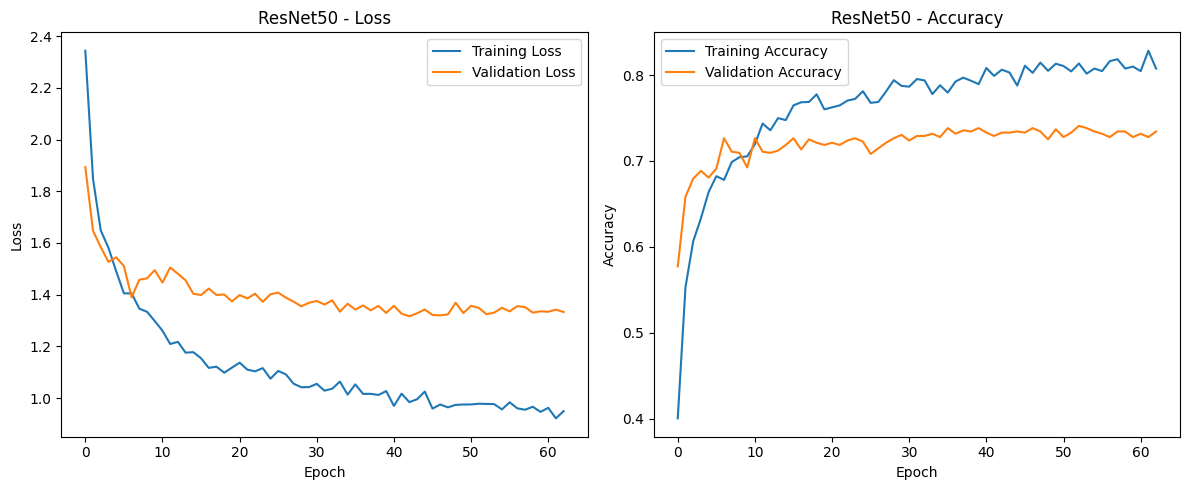

In [27]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'{model_name}_training_history.png')
plt.show()


In [28]:
# Plot learning rate if available
if 'lr' in history.history:
    plt.figure(figsize=(8, 3))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.savefig(f'{model_name}_learning_rate.png')
    plt.show()

# Evaluate the model
print(f"\nEvaluating {model_name} model...")
train_metrics = evaluate_model(resnet50_model, train_gen, classes)
val_metrics = evaluate_model(resnet50_model, val_gen, classes)
test_metrics = evaluate_model(resnet50_model, test_gen, classes)


Evaluating ResNet50 model...


In [29]:
# Display metrics
print(f"\n{model_name} Results:")
print(f"Training - Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, "
      f"Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc']:.4f}")

print(f"Validation - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, "
      f"Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1_score']:.4f}, AUC: {val_metrics['auc']:.4f}")

print(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
      f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc']:.4f}")

# Save metrics to file
with open(f'{model_name}_metrics.txt', 'w') as f:
    f.write(f"{model_name} Results:\n")
    f.write(f"Training - Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, "
            f"Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc']:.4f}\n")
    f.write(f"Validation - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, "
            f"Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1_score']:.4f}, AUC: {val_metrics['auc']:.4f}\n")
    f.write(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
            f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc']:.4f}\n")

print(f"{model_name} model training and evaluation complete!")


ResNet50 Results:
Training - Accuracy: 0.9229, Precision: 0.9255, Recall: 0.9229, F1: 0.9221, AUC: 0.9966
Validation - Accuracy: 0.7408, Precision: 0.7377, Recall: 0.7408, F1: 0.7327, AUC: 0.9576
Test - Accuracy: 0.7453, Precision: 0.7535, Recall: 0.7453, F1: 0.7386, AUC: 0.9625
ResNet50 model training and evaluation complete!


2. ResNet100 Model

In [46]:
# Import ResNet101
from tensorflow.keras.applications import ResNet101

def create_resnet101_classifier(input_shape, num_classes):
    """
    Create a transfer learning model for waste classification using ResNet101
    """
    # Initialize ResNet101 base model
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Get the output from the base model
    x = base_model.output

    # Add custom classification head with regularization techniques
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)  # 20% dropout rate as specified

    # Final classification layer with softmax
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    # Create and compile the model with lower learning rate
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Optimized lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [47]:
# Set up model name and create it
model_name = 'ResNet101'  # The assignment mentioned ResNet100, but the standard model is ResNet101
input_shape = (*image_size, 3)
resnet101_model = create_resnet101_classifier(input_shape, num_classes)

# Set up callbacks for ResNet101 with the same DelayedEarlyStopping
callbacks = [
    DelayedEarlyStopping(
        min_epochs=50,            # Start monitoring only after 50 epochs
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        f'{model_name}_waste_classifier.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Add learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [48]:
# Train the model
print(f"Training {model_name} model with minimum 50 epochs...")
epochs = 100  # Train for 100 epochs with early stopping
history_resnet101 = resnet101_model.fit(
    train_gen,  # Reuse existing generator (no normalization)
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Training ResNet101 model with minimum 50 epochs...
Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3170 - loss: 2.6118
Epoch 1: val_loss improved from inf to 1.79320, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 98s 130ms/step - accuracy: 0.3171 - loss: 2.6112 - val_accuracy: 0.5929 - val_loss: 1.7932 - learning_rate: 1.0000e-04
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5560 - loss: 1.8719
Epoch 2: val_loss improved from 1.79320 to 1.60572, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 66s 108ms/step - accuracy: 0.5560 - loss: 1.8718 - val_accuracy: 0.6492 - val_loss: 1.6057 - learning_rate: 1.0000e-04
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6132 - loss: 1.6348
Epoch 3: val_loss improved from 1.60572 to 1.55019, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.6132 - loss: 1.6348 - val_accuracy: 0.6715 - val_loss: 1.5502 - learning_rate: 1.0000e-04
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6392 - loss: 1.5374
Epoch 4: val_loss did not improve from 1.55019
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.6392 - loss: 1.5374 - val_accuracy: 0.6584 - val_loss: 1.5674 - learning_rate: 1.0000e-04
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6373 - loss: 1.5108
Epoch 5: val_loss improved from 1.55019 to 1.46986, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.6374 - loss: 1.5107 - val_accuracy: 0.6990 - val_loss: 1.4699 - learning_rate: 1.0000e-04
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6869 - loss: 1.3850
Epoch 6: val_loss improved from 1.46986 to 1.42505, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 108ms/step - accuracy: 0.6869 - loss: 1.3851 - val_accuracy: 0.6950 - val_loss: 1.4250 - learning_rate: 1.0000e-04
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6883 - loss: 1.3934
Epoch 7: val_loss improved from 1.42505 to 1.37679, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.6883 - loss: 1.3934 - val_accuracy: 0.7042 - val_loss: 1.3768 - learning_rate: 1.0000e-04
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7011 - loss: 1.3334
Epoch 8: val_loss improved from 1.37679 to 1.33946, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.7011 - loss: 1.3334 - val_accuracy: 0.7225 - val_loss: 1.3395 - learning_rate: 1.0000e-04
Epoch 9/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7267 - loss: 1.2675
Epoch 9: val_loss did not improve from 1.33946
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7267 - loss: 1.2675 - val_accuracy: 0.7199 - val_loss: 1.3713 - learning_rate: 1.0000e-04
Epoch 10/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7203 - loss: 1.2713
Epoch 10: val_loss did not improve from 1.33946
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7202 - loss: 1.2713 - val_accuracy: 0.7238 - val_loss: 1.3403 - learning_rate: 1.0000e-04
Epoch 11/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7524 - loss: 1.2019
Epoch 11: val_loss did not improve from 1.33946
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7524 - loss: 1.2019 - val_accuracy: 0.7173 - val_loss: 1.3632 - learning_rate: 1.0000e-04

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7281 - loss: 1.2206 - val_accuracy: 0.7134 - val_loss: 1.3210 - learning_rate: 1.0000e-04
Epoch 13/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7214 - loss: 1.2205
Epoch 13: val_loss did not improve from 1.32096
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7214 - loss: 1.2205 - val_accuracy: 0.7160 - val_loss: 1.3531 - learning_rate: 1.0000e-04
Epoch 14/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7552 - loss: 1.1462
Epoch 14: val_loss did not improve from 1.32096
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7552 - loss: 1.1462 - val_accuracy: 0.7081 - val_loss: 1.3466 - learning_rate: 1.0000e-04
Epoch 15/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7661 - loss: 1.1528
Epoch 15: val_loss improved from 1.32096 to 1.32024, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7661 - loss: 1.1528 - val_accuracy: 0.7147 - val_loss: 1.3202 - learning_rate: 1.0000e-04
Epoch 16/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7597 - loss: 1.1705
Epoch 16: val_loss improved from 1.32024 to 1.29836, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 108ms/step - accuracy: 0.7597 - loss: 1.1705 - val_accuracy: 0.7317 - val_loss: 1.2984 - learning_rate: 1.0000e-04
Epoch 17/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7615 - loss: 1.1063
Epoch 17: val_loss improved from 1.29836 to 1.24124, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.7615 - loss: 1.1063 - val_accuracy: 0.7382 - val_loss: 1.2412 - learning_rate: 1.0000e-04
Epoch 18/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7711 - loss: 1.0953
Epoch 18: val_loss improved from 1.24124 to 1.23989, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.7711 - loss: 1.0953 - val_accuracy: 0.7330 - val_loss: 1.2399 - learning_rate: 1.0000e-04
Epoch 19/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7710 - loss: 1.0601
Epoch 19: val_loss did not improve from 1.23989
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7710 - loss: 1.0601 - val_accuracy: 0.7421 - val_loss: 1.2499 - learning_rate: 1.0000e-04
Epoch 20/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7907 - loss: 1.0794
Epoch 20: val_loss improved from 1.23989 to 1.22848, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7907 - loss: 1.0794 - val_accuracy: 0.7421 - val_loss: 1.2285 - learning_rate: 1.0000e-04
Epoch 21/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7715 - loss: 1.0708
Epoch 21: val_loss did not improve from 1.22848
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7715 - loss: 1.0708 - val_accuracy: 0.7225 - val_loss: 1.2401 - learning_rate: 1.0000e-04
Epoch 22/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7842 - loss: 1.0541
Epoch 22: val_loss improved from 1.22848 to 1.20568, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7842 - loss: 1.0541 - val_accuracy: 0.7461 - val_loss: 1.2057 - learning_rate: 1.0000e-04
Epoch 23/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7813 - loss: 1.0406
Epoch 23: val_loss did not improve from 1.20568
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7813 - loss: 1.0406 - val_accuracy: 0.7330 - val_loss: 1.2757 - learning_rate: 1.0000e-04
Epoch 24/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8009 - loss: 1.0159
Epoch 24: val_loss did not improve from 1.20568
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8009 - loss: 1.0160 - val_accuracy: 0.7474 - val_loss: 1.2180 - learning_rate: 1.0000e-04
Epoch 25/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8002 - loss: 1.0099
Epoch 25: val_loss did not improve from 1.20568
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8002 - loss: 1.0099 - val_accuracy: 0.7565 - val_loss: 1.2244 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 106ms/step - accuracy: 0.8015 - loss: 0.9681 - val_accuracy: 0.7723 - val_loss: 1.1622 - learning_rate: 1.0000e-04
Epoch 28/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7992 - loss: 1.0226
Epoch 28: val_loss did not improve from 1.16215
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.7992 - loss: 1.0226 - val_accuracy: 0.7618 - val_loss: 1.1743 - learning_rate: 1.0000e-04
Epoch 29/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8092 - loss: 0.9754
Epoch 29: val_loss did not improve from 1.16215
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8092 - loss: 0.9754 - val_accuracy: 0.7592 - val_loss: 1.1905 - learning_rate: 1.0000e-04
Epoch 30/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8155 - loss: 0.9418
Epoch 30: val_loss did not improve from 1.16215
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8155 - loss: 0.9418 - val_accuracy: 0.7539 - val_loss: 1.1960 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.8199 - loss: 0.9332 - val_accuracy: 0.7500 - val_loss: 1.1547 - learning_rate: 5.0000e-05
Epoch 34/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8174 - loss: 0.9213
Epoch 34: val_loss did not improve from 1.15472
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.8174 - loss: 0.9213 - val_accuracy: 0.7421 - val_loss: 1.1758 - learning_rate: 5.0000e-05
Epoch 35/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8092 - loss: 0.9287
Epoch 35: val_loss improved from 1.15472 to 1.14851, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.8093 - loss: 0.9287 - val_accuracy: 0.7579 - val_loss: 1.1485 - learning_rate: 5.0000e-05
Epoch 36/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8237 - loss: 0.9154
Epoch 36: val_loss did not improve from 1.14851
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8237 - loss: 0.9154 - val_accuracy: 0.7448 - val_loss: 1.1760 - learning_rate: 5.0000e-05
Epoch 37/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8307 - loss: 0.8738
Epoch 37: val_loss did not improve from 1.14851
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8307 - loss: 0.8738 - val_accuracy: 0.7539 - val_loss: 1.1789 - learning_rate: 5.0000e-05
Epoch 38/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8231 - loss: 0.8669
Epoch 38: val_loss did not improve from 1.14851
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8231 - loss: 0.8669 - val_accuracy: 0.7618 - val_loss: 1.1733 - learning_rate: 5.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.8345 - loss: 0.8456 - val_accuracy: 0.7448 - val_loss: 1.1421 - learning_rate: 5.0000e-05
Epoch 40/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8465 - loss: 0.8459
Epoch 40: val_loss did not improve from 1.14210
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.8465 - loss: 0.8459 - val_accuracy: 0.7513 - val_loss: 1.1779 - learning_rate: 5.0000e-05
Epoch 41/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8322 - loss: 0.8624
Epoch 41: val_loss did not improve from 1.14210
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8322 - loss: 0.8625 - val_accuracy: 0.7487 - val_loss: 1.1602 - learning_rate: 5.0000e-05
Epoch 42/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8197 - loss: 0.9127
Epoch 42: val_loss improved from 1.14210 to 1.13755, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 106ms/step - accuracy: 0.8197 - loss: 0.9126 - val_accuracy: 0.7618 - val_loss: 1.1375 - learning_rate: 5.0000e-05
Epoch 43/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8181 - loss: 0.8847
Epoch 43: val_loss did not improve from 1.13755
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8181 - loss: 0.8847 - val_accuracy: 0.7579 - val_loss: 1.1569 - learning_rate: 5.0000e-05
Epoch 44/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8406 - loss: 0.8557
Epoch 44: val_loss did not improve from 1.13755
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8405 - loss: 0.8557 - val_accuracy: 0.7592 - val_loss: 1.1536 - learning_rate: 5.0000e-05
Epoch 45/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8281 - loss: 0.8654
Epoch 45: val_loss did not improve from 1.13755
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8282 - loss: 0.8653 - val_accuracy: 0.7552 - val_loss: 1.1432 - learning_rate: 5.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.8638 - loss: 0.8016 - val_accuracy: 0.7579 - val_loss: 1.1363 - learning_rate: 1.2500e-05
Epoch 55/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8551 - loss: 0.7830
Epoch 55: val_loss did not improve from 1.13632
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.8551 - loss: 0.7830 - val_accuracy: 0.7592 - val_loss: 1.1377 - learning_rate: 1.2500e-05
Epoch 56/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8505 - loss: 0.8008
Epoch 56: val_loss did not improve from 1.13632
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8505 - loss: 0.8008 - val_accuracy: 0.7526 - val_loss: 1.1446 - learning_rate: 1.2500e-05
Epoch 57/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8610 - loss: 0.7815
Epoch 57: val_loss improved from 1.13632 to 1.12330, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.8610 - loss: 0.7815 - val_accuracy: 0.7644 - val_loss: 1.1233 - learning_rate: 1.2500e-05
Epoch 58/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8618 - loss: 0.7698
Epoch 58: val_loss improved from 1.12330 to 1.12127, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.8618 - loss: 0.7699 - val_accuracy: 0.7592 - val_loss: 1.1213 - learning_rate: 1.2500e-05
Epoch 59/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8612 - loss: 0.7779
Epoch 59: val_loss did not improve from 1.12127
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8612 - loss: 0.7778 - val_accuracy: 0.7565 - val_loss: 1.1405 - learning_rate: 1.2500e-05
Epoch 60/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8525 - loss: 0.7943
Epoch 60: val_loss did not improve from 1.12127
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8525 - loss: 0.7943 - val_accuracy: 0.7592 - val_loss: 1.1224 - learning_rate: 1.2500e-05
Epoch 61/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8670 - loss: 0.7491
Epoch 61: val_loss improved from 1.12127 to 1.11254, saving model to ResNet101_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.8670 - loss: 0.7492 - val_accuracy: 0.7657 - val_loss: 1.1125 - learning_rate: 1.2500e-05
Epoch 62/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8619 - loss: 0.7699
Epoch 62: val_loss did not improve from 1.11254
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.8619 - loss: 0.7699 - val_accuracy: 0.7683 - val_loss: 1.1248 - learning_rate: 1.2500e-05
Epoch 63/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8521 - loss: 0.7940
Epoch 63: val_loss did not improve from 1.11254
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8521 - loss: 0.7940 - val_accuracy: 0.7618 - val_loss: 1.1199 - learning_rate: 1.2500e-05
Epoch 64/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8689 - loss: 0.7693
Epoch 64: val_loss did not improve from 1.11254
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8689 - loss: 0.7693 - val_accuracy: 0.7579 - val_loss: 1.1208 - learning_rate: 1.2500e-

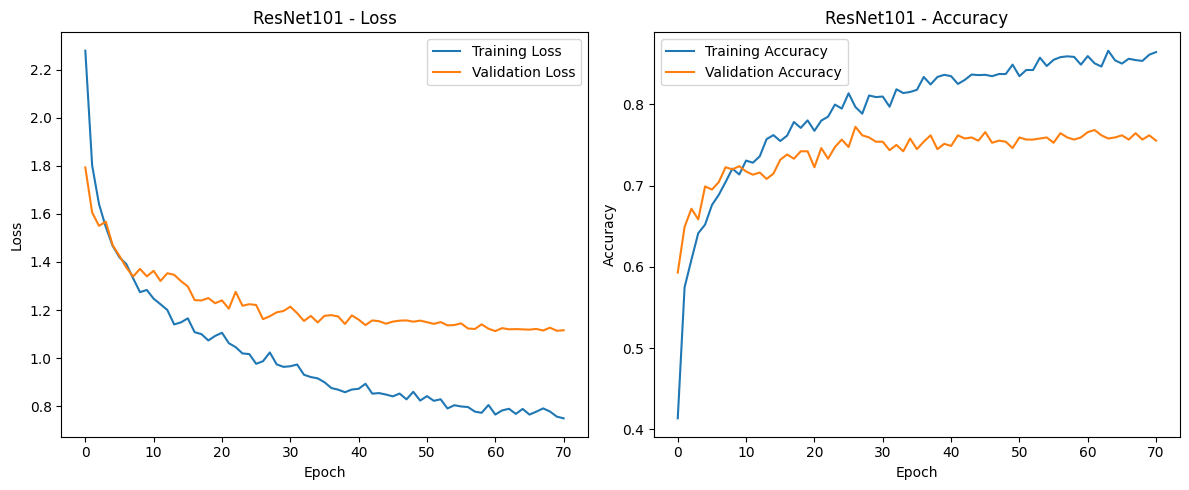

In [49]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet101.history['loss'], label='Training Loss')
plt.plot(history_resnet101.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet101.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet101.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'{model_name}_training_history.png')
plt.show()

In [50]:
# Plot learning rate if available
if 'lr' in history_resnet101.history:
    plt.figure(figsize=(8, 3))
    plt.plot(history_resnet101.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.savefig(f'{model_name}_learning_rate.png')
    plt.show()

# Evaluate the model
print(f"\nEvaluating {model_name} model...")
train_metrics = evaluate_model(resnet101_model, train_gen, classes)
val_metrics = evaluate_model(resnet101_model, val_gen, classes)
test_metrics = evaluate_model(resnet101_model, test_gen, classes)



Evaluating ResNet101 model...


In [51]:
# Display metrics
print(f"\n{model_name} Results:")
print(f"Training - Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, "
      f"Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc']:.4f}")

print(f"Validation - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, "
      f"Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1_score']:.4f}, AUC: {val_metrics['auc']:.4f}")

print(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
      f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc']:.4f}")

# Save metrics to file
with open(f'{model_name}_metrics.txt', 'w') as f:
    f.write(f"{model_name} Results:\n")
    f.write(f"Training - Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, "
            f"Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc']:.4f}\n")
    f.write(f"Validation - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, "
            f"Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1_score']:.4f}, AUC: {val_metrics['auc']:.4f}\n")
    f.write(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
            f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc']:.4f}\n")

print(f"{model_name} model training and evaluation complete!")


ResNet101 Results:
Training - Accuracy: 0.9578, Precision: 0.9588, Recall: 0.9578, F1: 0.9576, AUC: 0.9986
Validation - Accuracy: 0.7657, Precision: 0.7648, Recall: 0.7657, F1: 0.7614, AUC: 0.9659
Test - Accuracy: 0.7495, Precision: 0.7456, Recall: 0.7495, F1: 0.7425, AUC: 0.9615
ResNet101 model training and evaluation complete!


3. VGG16 Model

In [33]:
def create_vgg16_classifier(input_shape, num_classes):
    """
    Create a transfer learning model for waste classification using VGG16
    """
    # Initialize VGG16 base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Get the output from the base model
    x = base_model.output

    # Add custom classification head with regularization techniques
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)  # 20% dropout rate as specified

    # Final classification layer with softmax
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    # Create and compile the model with lower learning rate
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Optimized lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [34]:
model_name = 'VGG16'
input_shape = (*image_size, 3)
vgg16_model = create_vgg16_classifier(input_shape, num_classes)

callbacks = [
    DelayedEarlyStopping(
        min_epochs=50,            # Start monitoring only after 50 epochs
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        f'{model_name}_waste_classifier.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Add learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]


In [35]:
print(f"Training {model_name} model with minimum 50 epochs...")
epochs = 100  # Train for 100 epochs with early stopping
history_vgg16 = vgg16_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Training VGG16 model with minimum 50 epochs...
Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1936 - loss: 3.0173
Epoch 1: val_loss improved from inf to 2.33029, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 69s 107ms/step - accuracy: 0.1937 - loss: 3.0167 - val_accuracy: 0.3783 - val_loss: 2.3303 - learning_rate: 1.0000e-04
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4033 - loss: 2.1347
Epoch 2: val_loss improved from 2.33029 to 1.96781, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.4034 - loss: 2.1346 - val_accuracy: 0.4987 - val_loss: 1.9678 - learning_rate: 1.0000e-04
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4804 - loss: 1.9196
Epoch 3: val_loss improved from 1.96781 to 1.78951, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.4804 - loss: 1.9196 - val_accuracy: 0.5524 - val_loss: 1.7895 - learning_rate: 1.0000e-04
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5350 - loss: 1.7524
Epoch 4: val_loss improved from 1.78951 to 1.72174, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.5350 - loss: 1.7525 - val_accuracy: 0.5641 - val_loss: 1.7217 - learning_rate: 1.0000e-04
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5514 - loss: 1.7087
Epoch 5: val_loss improved from 1.72174 to 1.65007, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.5514 - loss: 1.7087 - val_accuracy: 0.6034 - val_loss: 1.6501 - learning_rate: 1.0000e-04
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5726 - loss: 1.5993
Epoch 6: val_loss improved from 1.65007 to 1.62709, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.5726 - loss: 1.5993 - val_accuracy: 0.6060 - val_loss: 1.6271 - learning_rate: 1.0000e-04
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5821 - loss: 1.5285
Epoch 7: val_loss improved from 1.62709 to 1.58949, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.5821 - loss: 1.5285 - val_accuracy: 0.6139 - val_loss: 1.5895 - learning_rate: 1.0000e-04
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5902 - loss: 1.5323
Epoch 8: val_loss improved from 1.58949 to 1.55324, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.5902 - loss: 1.5324 - val_accuracy: 0.6466 - val_loss: 1.5532 - learning_rate: 1.0000e-04
Epoch 9/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5952 - loss: 1.4941
Epoch 9: val_loss improved from 1.55324 to 1.51142, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.5952 - loss: 1.4941 - val_accuracy: 0.6466 - val_loss: 1.5114 - learning_rate: 1.0000e-04
Epoch 10/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6136 - loss: 1.4811
Epoch 10: val_loss improved from 1.51142 to 1.51037, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6136 - loss: 1.4812 - val_accuracy: 0.6440 - val_loss: 1.5104 - learning_rate: 1.0000e-04
Epoch 11/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6274 - loss: 1.3983
Epoch 11: val_loss improved from 1.51037 to 1.50616, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6274 - loss: 1.3983 - val_accuracy: 0.6466 - val_loss: 1.5062 - learning_rate: 1.0000e-04
Epoch 12/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6344 - loss: 1.4177
Epoch 12: val_loss improved from 1.50616 to 1.49799, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.6344 - loss: 1.4177 - val_accuracy: 0.6414 - val_loss: 1.4980 - learning_rate: 1.0000e-04
Epoch 13/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6327 - loss: 1.3751
Epoch 13: val_loss improved from 1.49799 to 1.46984, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6327 - loss: 1.3751 - val_accuracy: 0.6558 - val_loss: 1.4698 - learning_rate: 1.0000e-04
Epoch 14/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6411 - loss: 1.3714
Epoch 14: val_loss improved from 1.46984 to 1.44223, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6411 - loss: 1.3714 - val_accuracy: 0.6688 - val_loss: 1.4422 - learning_rate: 1.0000e-04
Epoch 15/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6310 - loss: 1.3592
Epoch 15: val_loss did not improve from 1.44223
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6310 - loss: 1.3592 - val_accuracy: 0.6715 - val_loss: 1.4590 - learning_rate: 1.0000e-04
Epoch 16/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6556 - loss: 1.2922
Epoch 16: val_loss improved from 1.44223 to 1.41604, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6556 - loss: 1.2923 - val_accuracy: 0.6819 - val_loss: 1.4160 - learning_rate: 1.0000e-04
Epoch 17/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6732 - loss: 1.3023
Epoch 17: val_loss did not improve from 1.41604
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6732 - loss: 1.3023 - val_accuracy: 0.6610 - val_loss: 1.4326 - learning_rate: 1.0000e-04
Epoch 18/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6398 - loss: 1.3573
Epoch 18: val_loss improved from 1.41604 to 1.40863, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6398 - loss: 1.3573 - val_accuracy: 0.6636 - val_loss: 1.4086 - learning_rate: 1.0000e-04
Epoch 19/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6697 - loss: 1.2850
Epoch 19: val_loss improved from 1.40863 to 1.39294, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6697 - loss: 1.2850 - val_accuracy: 0.6754 - val_loss: 1.3929 - learning_rate: 1.0000e-04
Epoch 20/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6598 - loss: 1.2757
Epoch 20: val_loss improved from 1.39294 to 1.36696, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6598 - loss: 1.2757 - val_accuracy: 0.6885 - val_loss: 1.3670 - learning_rate: 1.0000e-04
Epoch 21/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6514 - loss: 1.3127
Epoch 21: val_loss did not improve from 1.36696
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6514 - loss: 1.3126 - val_accuracy: 0.6649 - val_loss: 1.3975 - learning_rate: 1.0000e-04
Epoch 22/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6810 - loss: 1.2344
Epoch 22: val_loss did not improve from 1.36696
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6810 - loss: 1.2344 - val_accuracy: 0.6754 - val_loss: 1.3674 - learning_rate: 1.0000e-04
Epoch 23/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6667 - loss: 1.2672
Epoch 23: val_loss did not improve from 1.36696
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.6667 - loss: 1.2672 - val_accuracy: 0.6702 - val_loss: 1.3893 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6554 - loss: 1.2742 - val_accuracy: 0.6806 - val_loss: 1.3411 - learning_rate: 1.0000e-04
Epoch 25/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6718 - loss: 1.2289
Epoch 25: val_loss did not improve from 1.34114
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6718 - loss: 1.2289 - val_accuracy: 0.6688 - val_loss: 1.3433 - learning_rate: 1.0000e-04
Epoch 26/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6963 - loss: 1.1820
Epoch 26: val_loss improved from 1.34114 to 1.33978, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6962 - loss: 1.1820 - val_accuracy: 0.6715 - val_loss: 1.3398 - learning_rate: 1.0000e-04
Epoch 27/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6592 - loss: 1.2746
Epoch 27: val_loss improved from 1.33978 to 1.32576, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6592 - loss: 1.2746 - val_accuracy: 0.6819 - val_loss: 1.3258 - learning_rate: 1.0000e-04
Epoch 28/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6834 - loss: 1.1973
Epoch 28: val_loss improved from 1.32576 to 1.30997, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6834 - loss: 1.1973 - val_accuracy: 0.6688 - val_loss: 1.3100 - learning_rate: 1.0000e-04
Epoch 29/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6835 - loss: 1.2060
Epoch 29: val_loss improved from 1.30997 to 1.28634, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6835 - loss: 1.2060 - val_accuracy: 0.6793 - val_loss: 1.2863 - learning_rate: 1.0000e-04
Epoch 30/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6944 - loss: 1.1868
Epoch 30: val_loss improved from 1.28634 to 1.27717, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.6944 - loss: 1.1868 - val_accuracy: 0.6819 - val_loss: 1.2772 - learning_rate: 1.0000e-04
Epoch 31/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7011 - loss: 1.1687
Epoch 31: val_loss did not improve from 1.27717
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7011 - loss: 1.1688 - val_accuracy: 0.6793 - val_loss: 1.3144 - learning_rate: 1.0000e-04
Epoch 32/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6844 - loss: 1.1949
Epoch 32: val_loss did not improve from 1.27717
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6844 - loss: 1.1949 - val_accuracy: 0.6872 - val_loss: 1.3059 - learning_rate: 1.0000e-04
Epoch 33/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6954 - loss: 1.1759
Epoch 33: val_loss did not improve from 1.27717
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6954 - loss: 1.1759 - val_accuracy: 0.6859 - val_loss: 1.2822 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7128 - loss: 1.1481 - val_accuracy: 0.6793 - val_loss: 1.2571 - learning_rate: 5.0000e-05
Epoch 39/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7145 - loss: 1.0946
Epoch 39: val_loss did not improve from 1.25706
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7145 - loss: 1.0946 - val_accuracy: 0.6793 - val_loss: 1.2675 - learning_rate: 5.0000e-05
Epoch 40/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6942 - loss: 1.1817
Epoch 40: val_loss did not improve from 1.25706
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6942 - loss: 1.1817 - val_accuracy: 0.6780 - val_loss: 1.2895 - learning_rate: 5.0000e-05
Epoch 41/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7018 - loss: 1.1976
Epoch 41: val_loss did not improve from 1.25706
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7018 - loss: 1.1975 - val_accuracy: 0.6780 - val_loss: 1.2879 - learning_rate: 5.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7110 - loss: 1.0954 - val_accuracy: 0.6832 - val_loss: 1.2461 - learning_rate: 5.0000e-05
Epoch 44/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7010 - loss: 1.1146
Epoch 44: val_loss did not improve from 1.24607
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7010 - loss: 1.1147 - val_accuracy: 0.6898 - val_loss: 1.2715 - learning_rate: 5.0000e-05
Epoch 45/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7138 - loss: 1.1240
Epoch 45: val_loss did not improve from 1.24607
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7138 - loss: 1.1240 - val_accuracy: 0.6846 - val_loss: 1.2786 - learning_rate: 5.0000e-05
Epoch 46/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7171 - loss: 1.1019
Epoch 46: val_loss did not improve from 1.24607
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.7171 - loss: 1.1019 - val_accuracy: 0.6885 - val_loss: 1.2613 - learning_rate: 5.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7063 - loss: 1.1086 - val_accuracy: 0.7042 - val_loss: 1.2364 - learning_rate: 5.0000e-05
Epoch 48/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7149 - loss: 1.0552
Epoch 48: val_loss did not improve from 1.23641
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7149 - loss: 1.0553 - val_accuracy: 0.6885 - val_loss: 1.2388 - learning_rate: 5.0000e-05
Epoch 49/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7084 - loss: 1.1215
Epoch 49: val_loss did not improve from 1.23641
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7084 - loss: 1.1215 - val_accuracy: 0.6846 - val_loss: 1.2652 - learning_rate: 5.0000e-05
Epoch 50/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7213 - loss: 1.1282
Epoch 50: val_loss did not improve from 1.23641
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7213 - loss: 1.1281 - val_accuracy: 0.6898 - val_loss: 1.2644 - learning_rate: 5.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7208 - loss: 1.0833 - val_accuracy: 0.6976 - val_loss: 1.2357 - learning_rate: 5.0000e-05
Epoch 52/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7105 - loss: 1.1112
Epoch 52: val_loss improved from 1.23574 to 1.22202, saving model to VGG16_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7105 - loss: 1.1112 - val_accuracy: 0.6950 - val_loss: 1.2220 - learning_rate: 5.0000e-05
Epoch 53/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7285 - loss: 1.0845
Epoch 53: val_loss did not improve from 1.22202
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7285 - loss: 1.0845 - val_accuracy: 0.6937 - val_loss: 1.2255 - learning_rate: 5.0000e-05
Epoch 54/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7429 - loss: 1.0272
Epoch 54: val_loss did not improve from 1.22202
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7428 - loss: 1.0272 - val_accuracy: 0.6898 - val_loss: 1.2472 - learning_rate: 5.0000e-05
Epoch 55/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6982 - loss: 1.1214
Epoch 55: val_loss did not improve from 1.22202
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6982 - loss: 1.1214 - val_accuracy: 0.6924 - val_loss: 1.2403 - learning_rate: 5.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7263 - loss: 1.0437 - val_accuracy: 0.7042 - val_loss: 1.2025 - learning_rate: 5.0000e-05
Epoch 57/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7181 - loss: 1.0694
Epoch 57: val_loss did not improve from 1.20249
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7181 - loss: 1.0694 - val_accuracy: 0.6819 - val_loss: 1.2410 - learning_rate: 5.0000e-05
Epoch 58/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7063 - loss: 1.0933
Epoch 58: val_loss did not improve from 1.20249
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7063 - loss: 1.0933 - val_accuracy: 0.6937 - val_loss: 1.2291 - learning_rate: 5.0000e-05
Epoch 59/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7318 - loss: 1.0573
Epoch 59: val_loss did not improve from 1.20249
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7318 - loss: 1.0573 - val_accuracy: 0.6911 - val_loss: 1.2457 - learning_rate: 5.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7222 - loss: 1.0502 - val_accuracy: 0.7016 - val_loss: 1.1930 - learning_rate: 2.5000e-05
Epoch 65/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7291 - loss: 1.0412
Epoch 65: val_loss did not improve from 1.19296
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7290 - loss: 1.0412 - val_accuracy: 0.6937 - val_loss: 1.2378 - learning_rate: 2.5000e-05
Epoch 66/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7321 - loss: 1.0084
Epoch 66: val_loss did not improve from 1.19296
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.7321 - loss: 1.0084 - val_accuracy: 0.7042 - val_loss: 1.2219 - learning_rate: 2.5000e-05
Epoch 67/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7218 - loss: 1.0699
Epoch 67: val_loss did not improve from 1.19296
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7218 - loss: 1.0699 - val_accuracy: 0.7107 - val_loss: 1.1967 - learning_rate: 2.5000e-

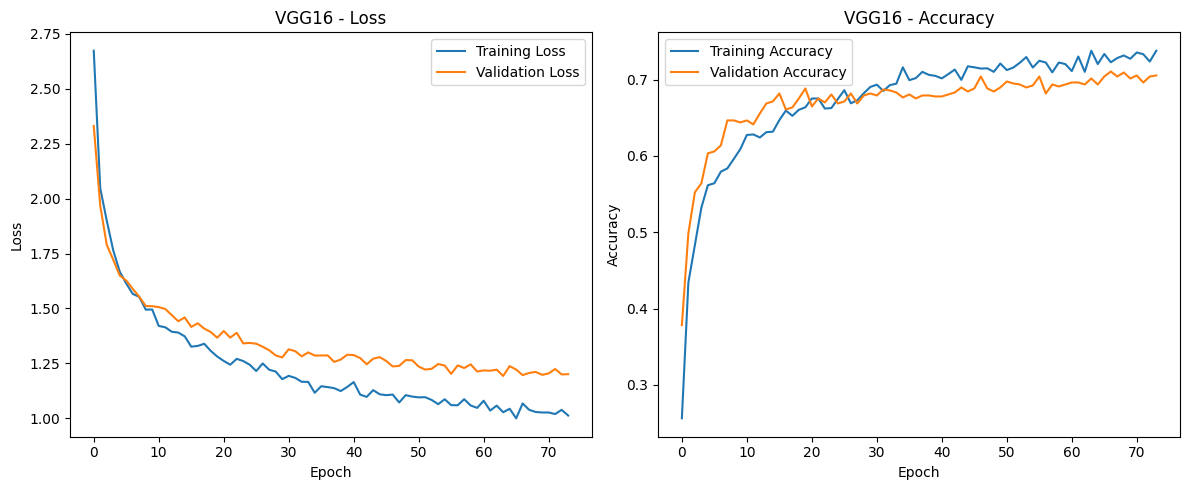

In [36]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'{model_name}_training_history.png')
plt.show()

In [37]:
# Plot learning rate if available
if 'lr' in history_vgg16.history:
    plt.figure(figsize=(8, 3))
    plt.plot(history_vgg16.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.savefig(f'{model_name}_learning_rate.png')
    plt.show()

# Evaluate the model
print(f"\nEvaluating {model_name} model...")
train_metrics = evaluate_model(vgg16_model, train_gen, classes)
val_metrics = evaluate_model(vgg16_model, val_gen, classes)
test_metrics = evaluate_model(vgg16_model, test_gen, classes)



Evaluating VGG16 model...


In [38]:
# Display metrics
print(f"\n{model_name} Results:")
print(f"Training - Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, "
      f"Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc']:.4f}")

print(f"Validation - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, "
      f"Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1_score']:.4f}, AUC: {val_metrics['auc']:.4f}")

print(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
      f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc']:.4f}")

# Save metrics to file
with open(f'{model_name}_metrics.txt', 'w') as f:
    f.write(f"{model_name} Results:\n")
    f.write(f"Training - Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, "
            f"Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc']:.4f}\n")
    f.write(f"Validation - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, "
            f"Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1_score']:.4f}, AUC: {val_metrics['auc']:.4f}\n")
    f.write(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
            f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc']:.4f}\n")

print(f"{model_name} model training and evaluation complete!")


VGG16 Results:
Training - Accuracy: 0.8794, Precision: 0.8796, Recall: 0.8794, F1: 0.8787, AUC: 0.9900
Validation - Accuracy: 0.7016, Precision: 0.6993, Recall: 0.7016, F1: 0.6904, AUC: 0.9443
Test - Accuracy: 0.7254, Precision: 0.7297, Recall: 0.7254, F1: 0.7212, AUC: 0.9522
VGG16 model training and evaluation complete!


4. EfficientNetB0 Model

In [40]:
def create_efficientnet_classifier(input_shape, num_classes):
    """
    Create a transfer learning model for waste classification using EfficientNetB0
    """
    # Initialize EfficientNetB0 base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Get the output from the base model
    x = base_model.output

    # Add custom classification head with regularization techniques
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)  # 20% dropout rate as specified

    # Final classification layer with softmax
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    # Create and compile the model with lower learning rate
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Optimized lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [41]:
# Set up model name and create it
model_name = 'EfficientNetB0'
input_shape = (*image_size, 3)
efficientnet_model = create_efficientnet_classifier(input_shape, num_classes)

callbacks = [
    DelayedEarlyStopping(
        min_epochs=50,            # Start monitoring only after 50 epochs
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        f'{model_name}_waste_classifier.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Add learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [42]:
# Train the model using the same non-normalized data generators
print(f"Training {model_name} model with minimum 50 epochs...")
epochs = 100  # Maximum number of epochs
history_efficientnet = efficientnet_model.fit(
    train_gen,  # Reuse existing generator (no normalization)
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Training EfficientNetB0 model with minimum 50 epochs...
Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2948 - loss: 2.7359
Epoch 1: val_loss improved from inf to 1.89394, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 110s 140ms/step - accuracy: 0.2950 - loss: 2.7353 - val_accuracy: 0.5641 - val_loss: 1.8939 - learning_rate: 1.0000e-04
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5460 - loss: 1.7898
Epoch 2: val_loss improved from 1.89394 to 1.62313, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.5461 - loss: 1.7896 - val_accuracy: 0.6518 - val_loss: 1.6231 - learning_rate: 1.0000e-04
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6324 - loss: 1.5521
Epoch 3: val_loss improved from 1.62313 to 1.48397, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.6325 - loss: 1.5521 - val_accuracy: 0.6806 - val_loss: 1.4840 - learning_rate: 1.0000e-04
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6810 - loss: 1.3990
Epoch 4: val_loss improved from 1.48397 to 1.46121, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.6810 - loss: 1.3990 - val_accuracy: 0.6937 - val_loss: 1.4612 - learning_rate: 1.0000e-04
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7170 - loss: 1.3159
Epoch 5: val_loss improved from 1.46121 to 1.38458, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7170 - loss: 1.3158 - val_accuracy: 0.7042 - val_loss: 1.3846 - learning_rate: 1.0000e-04
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7162 - loss: 1.2567
Epoch 6: val_loss did not improve from 1.38458
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7162 - loss: 1.2567 - val_accuracy: 0.7173 - val_loss: 1.3908 - learning_rate: 1.0000e-04
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7330 - loss: 1.2391
Epoch 7: val_loss improved from 1.38458 to 1.32430, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.7330 - loss: 1.2391 - val_accuracy: 0.7107 - val_loss: 1.3243 - learning_rate: 1.0000e-04
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7413 - loss: 1.1976
Epoch 8: val_loss improved from 1.32430 to 1.31027, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7413 - loss: 1.1977 - val_accuracy: 0.7251 - val_loss: 1.3103 - learning_rate: 1.0000e-04
Epoch 9/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7669 - loss: 1.1297
Epoch 9: val_loss did not improve from 1.31027
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7669 - loss: 1.1297 - val_accuracy: 0.7212 - val_loss: 1.3222 - learning_rate: 1.0000e-04
Epoch 10/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7519 - loss: 1.1326
Epoch 10: val_loss did not improve from 1.31027
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7519 - loss: 1.1326 - val_accuracy: 0.7291 - val_loss: 1.3186 - learning_rate: 1.0000e-04
Epoch 11/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7670 - loss: 1.1086
Epoch 11: val_loss did not improve from 1.31027
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7670 - loss: 1.1086 - val_accuracy: 0.7277 - val_loss: 1.3277 - learning_rate: 1.0000e-04

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7901 - loss: 1.0697 - val_accuracy: 0.7343 - val_loss: 1.2616 - learning_rate: 1.0000e-04
Epoch 13/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7866 - loss: 1.0489
Epoch 13: val_loss did not improve from 1.26156
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7866 - loss: 1.0489 - val_accuracy: 0.7395 - val_loss: 1.2770 - learning_rate: 1.0000e-04
Epoch 14/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7785 - loss: 1.0444
Epoch 14: val_loss did not improve from 1.26156
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.7785 - loss: 1.0444 - val_accuracy: 0.7343 - val_loss: 1.2666 - learning_rate: 1.0000e-04
Epoch 15/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8057 - loss: 1.0155
Epoch 15: val_loss improved from 1.26156 to 1.23982, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8057 - loss: 1.0155 - val_accuracy: 0.7435 - val_loss: 1.2398 - learning_rate: 1.0000e-04
Epoch 16/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8132 - loss: 0.9500
Epoch 16: val_loss improved from 1.23982 to 1.21263, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8131 - loss: 0.9500 - val_accuracy: 0.7605 - val_loss: 1.2126 - learning_rate: 1.0000e-04
Epoch 17/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8157 - loss: 0.9590
Epoch 17: val_loss did not improve from 1.21263
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8157 - loss: 0.9591 - val_accuracy: 0.7644 - val_loss: 1.2405 - learning_rate: 1.0000e-04
Epoch 18/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8030 - loss: 0.9748
Epoch 18: val_loss did not improve from 1.21263
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8030 - loss: 0.9748 - val_accuracy: 0.7605 - val_loss: 1.2167 - learning_rate: 1.0000e-04
Epoch 19/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8163 - loss: 0.9600
Epoch 19: val_loss did not improve from 1.21263
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8163 - loss: 0.9600 - val_accuracy: 0.7487 - val_loss: 1.2571 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8092 - loss: 0.9379 - val_accuracy: 0.7696 - val_loss: 1.1816 - learning_rate: 1.0000e-04
Epoch 22/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8200 - loss: 0.9543
Epoch 22: val_loss improved from 1.18158 to 1.16698, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8200 - loss: 0.9543 - val_accuracy: 0.7723 - val_loss: 1.1670 - learning_rate: 1.0000e-04
Epoch 23/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8254 - loss: 0.9214
Epoch 23: val_loss improved from 1.16698 to 1.16389, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8254 - loss: 0.9213 - val_accuracy: 0.7605 - val_loss: 1.1639 - learning_rate: 1.0000e-04
Epoch 24/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8358 - loss: 0.8740
Epoch 24: val_loss improved from 1.16389 to 1.16208, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.8358 - loss: 0.8741 - val_accuracy: 0.7696 - val_loss: 1.1621 - learning_rate: 1.0000e-04
Epoch 25/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8344 - loss: 0.9102
Epoch 25: val_loss did not improve from 1.16208
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8344 - loss: 0.9101 - val_accuracy: 0.7762 - val_loss: 1.1686 - learning_rate: 1.0000e-04
Epoch 26/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8285 - loss: 0.8518
Epoch 26: val_loss improved from 1.16208 to 1.13618, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8285 - loss: 0.8518 - val_accuracy: 0.7880 - val_loss: 1.1362 - learning_rate: 1.0000e-04
Epoch 27/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8291 - loss: 0.8890
Epoch 27: val_loss improved from 1.13618 to 1.12879, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8291 - loss: 0.8890 - val_accuracy: 0.7788 - val_loss: 1.1288 - learning_rate: 1.0000e-04
Epoch 28/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8074 - loss: 0.9187
Epoch 28: val_loss improved from 1.12879 to 1.11342, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.8074 - loss: 0.9187 - val_accuracy: 0.7788 - val_loss: 1.1134 - learning_rate: 1.0000e-04
Epoch 29/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8505 - loss: 0.8307
Epoch 29: val_loss did not improve from 1.11342
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8505 - loss: 0.8307 - val_accuracy: 0.7801 - val_loss: 1.1525 - learning_rate: 1.0000e-04
Epoch 30/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8414 - loss: 0.8402
Epoch 30: val_loss did not improve from 1.11342
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8414 - loss: 0.8402 - val_accuracy: 0.7853 - val_loss: 1.1581 - learning_rate: 1.0000e-04
Epoch 31/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8552 - loss: 0.8036
Epoch 31: val_loss did not improve from 1.11342
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8552 - loss: 0.8036 - val_accuracy: 0.7840 - val_loss: 1.1236 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8395 - loss: 0.8312 - val_accuracy: 0.7814 - val_loss: 1.1008 - learning_rate: 1.0000e-04
Epoch 34/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8575 - loss: 0.8079
Epoch 34: val_loss did not improve from 1.10082
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8575 - loss: 0.8079 - val_accuracy: 0.7788 - val_loss: 1.1206 - learning_rate: 1.0000e-04
Epoch 35/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8448 - loss: 0.8023
Epoch 35: val_loss did not improve from 1.10082
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.8448 - loss: 0.8024 - val_accuracy: 0.7827 - val_loss: 1.1226 - learning_rate: 1.0000e-04
Epoch 36/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8534 - loss: 0.7915
Epoch 36: val_loss did not improve from 1.10082
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.8534 - loss: 0.7915 - val_accuracy: 0.7853 - val_loss: 1.1302 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8570 - loss: 0.7963 - val_accuracy: 0.7840 - val_loss: 1.0913 - learning_rate: 1.0000e-04
Epoch 39/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8566 - loss: 0.7739
Epoch 39: val_loss improved from 1.09129 to 1.08867, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8566 - loss: 0.7739 - val_accuracy: 0.7840 - val_loss: 1.0887 - learning_rate: 1.0000e-04
Epoch 40/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8633 - loss: 0.7597
Epoch 40: val_loss did not improve from 1.08867
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8632 - loss: 0.7597 - val_accuracy: 0.8024 - val_loss: 1.0921 - learning_rate: 1.0000e-04
Epoch 41/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8683 - loss: 0.7504
Epoch 41: val_loss did not improve from 1.08867
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8683 - loss: 0.7504 - val_accuracy: 0.7919 - val_loss: 1.1046 - learning_rate: 1.0000e-04
Epoch 42/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8781 - loss: 0.7136
Epoch 42: val_loss improved from 1.08867 to 1.06021, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8781 - loss: 0.7136 - val_accuracy: 0.7971 - val_loss: 1.0602 - learning_rate: 1.0000e-04
Epoch 43/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8444 - loss: 0.7842
Epoch 43: val_loss did not improve from 1.06021
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8444 - loss: 0.7842 - val_accuracy: 0.7801 - val_loss: 1.0881 - learning_rate: 1.0000e-04
Epoch 44/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8548 - loss: 0.7565
Epoch 44: val_loss did not improve from 1.06021
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8548 - loss: 0.7565 - val_accuracy: 0.7893 - val_loss: 1.0826 - learning_rate: 1.0000e-04
Epoch 45/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8571 - loss: 0.7511
Epoch 45: val_loss did not improve from 1.06021
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.8571 - loss: 0.7512 - val_accuracy: 0.7853 - val_loss: 1.1027 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8863 - loss: 0.6539 - val_accuracy: 0.8037 - val_loss: 1.0592 - learning_rate: 1.0000e-05
Epoch 65/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8843 - loss: 0.6739
Epoch 65: val_loss improved from 1.05922 to 1.05711, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.8843 - loss: 0.6739 - val_accuracy: 0.7997 - val_loss: 1.0571 - learning_rate: 1.0000e-05
Epoch 66/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8845 - loss: 0.6684
Epoch 66: val_loss did not improve from 1.05711
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8845 - loss: 0.6684 - val_accuracy: 0.7997 - val_loss: 1.0617 - learning_rate: 1.0000e-05
Epoch 67/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8835 - loss: 0.6621
Epoch 67: val_loss did not improve from 1.05711
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8835 - loss: 0.6621 - val_accuracy: 0.7958 - val_loss: 1.0582 - learning_rate: 1.0000e-05
Epoch 68/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8869 - loss: 0.6535
Epoch 68: val_loss did not improve from 1.05711
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.8869 - loss: 0.6535 - val_accuracy: 0.7945 - val_loss: 1.0660 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - accuracy: 0.8852 - loss: 0.6471 - val_accuracy: 0.7971 - val_loss: 1.0519 - learning_rate: 1.0000e-05
Epoch 70/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8855 - loss: 0.6566
Epoch 70: val_loss did not improve from 1.05191
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8855 - loss: 0.6566 - val_accuracy: 0.7971 - val_loss: 1.0587 - learning_rate: 1.0000e-05
Epoch 71/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8908 - loss: 0.6448
Epoch 71: val_loss did not improve from 1.05191
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8908 - loss: 0.6449 - val_accuracy: 0.7932 - val_loss: 1.0698 - learning_rate: 1.0000e-05
Epoch 72/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8872 - loss: 0.6558
Epoch 72: val_loss did not improve from 1.05191
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8872 - loss: 0.6558 - val_accuracy: 0.7945 - val_loss: 1.0643 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8771 - loss: 0.6759 - val_accuracy: 0.8050 - val_loss: 1.0442 - learning_rate: 1.0000e-05
Epoch 78/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8868 - loss: 0.6529
Epoch 78: val_loss did not improve from 1.04425
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8868 - loss: 0.6529 - val_accuracy: 0.7997 - val_loss: 1.0523 - learning_rate: 1.0000e-05
Epoch 79/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8935 - loss: 0.6342
Epoch 79: val_loss improved from 1.04425 to 1.04363, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8935 - loss: 0.6342 - val_accuracy: 0.8010 - val_loss: 1.0436 - learning_rate: 1.0000e-05
Epoch 80/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8837 - loss: 0.6430
Epoch 80: val_loss improved from 1.04363 to 1.04027, saving model to EfficientNetB0_waste_classifier.h5


607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8836 - loss: 0.6430 - val_accuracy: 0.8010 - val_loss: 1.0403 - learning_rate: 1.0000e-05
Epoch 81/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9008 - loss: 0.6054
Epoch 81: val_loss did not improve from 1.04027
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.9007 - loss: 0.6054 - val_accuracy: 0.7984 - val_loss: 1.0522 - learning_rate: 1.0000e-05
Epoch 82/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8805 - loss: 0.6482
Epoch 82: val_loss did not improve from 1.04027
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8805 - loss: 0.6482 - val_accuracy: 0.8024 - val_loss: 1.0518 - learning_rate: 1.0000e-05
Epoch 83/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8891 - loss: 0.6436
Epoch 83: val_loss did not improve from 1.04027
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8891 - loss: 0.6436 - val_accuracy: 0.8076 - val_loss: 1.0510 - learning_rate: 1.0000e-

607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8866 - loss: 0.6119 - val_accuracy: 0.7971 - val_loss: 1.0376 - learning_rate: 1.0000e-05
Epoch 90/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8785 - loss: 0.6526
Epoch 90: val_loss did not improve from 1.03763
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8785 - loss: 0.6526 - val_accuracy: 0.7997 - val_loss: 1.0541 - learning_rate: 1.0000e-05
Epoch 91/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8680 - loss: 0.6787
Epoch 91: val_loss did not improve from 1.03763
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8680 - loss: 0.6786 - val_accuracy: 0.7945 - val_loss: 1.0481 - learning_rate: 1.0000e-05
Epoch 92/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8945 - loss: 0.6407
Epoch 92: val_loss did not improve from 1.03763
607/607 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - accuracy: 0.8945 - loss: 0.6407 - val_accuracy: 0.7971 - val_loss: 1.0472 - learning_rate: 1.0000e-

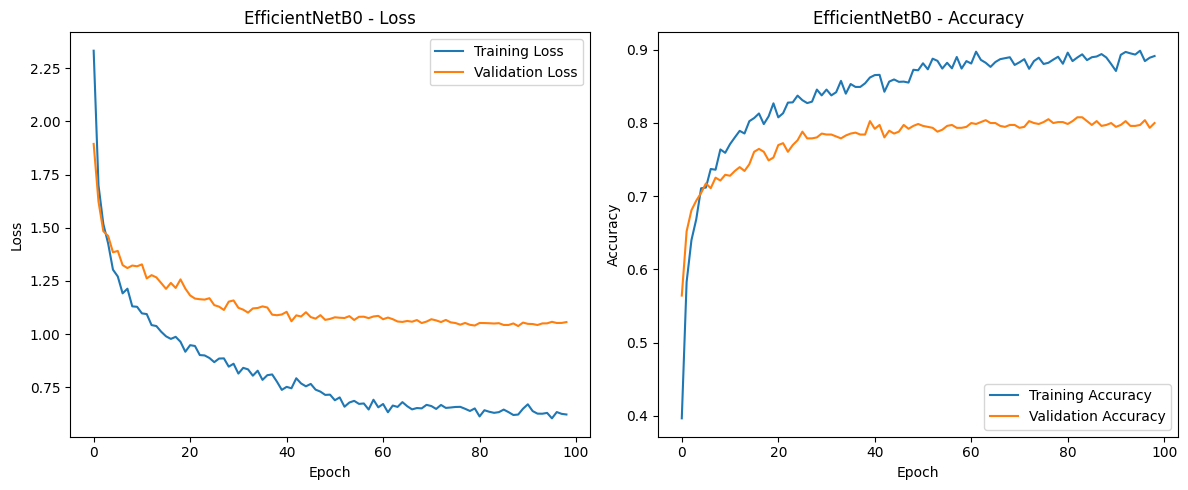

In [43]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'{model_name}_training_history.png')
plt.show()

In [44]:
# Plot learning rate if available
if 'lr' in history_efficientnet.history:
    plt.figure(figsize=(8, 3))
    plt.plot(history_efficientnet.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.savefig(f'{model_name}_learning_rate.png')
    plt.show()

# Evaluate the model
print(f"\nEvaluating {model_name} model...")
train_metrics = evaluate_model(efficientnet_model, train_gen, classes)
val_metrics = evaluate_model(efficientnet_model, val_gen, classes)
test_metrics = evaluate_model(efficientnet_model, test_gen, classes)



Evaluating EfficientNetB0 model...


In [45]:
# Display metrics
print(f"\n{model_name} Results:")
print(f"Training - Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, "
      f"Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc']:.4f}")

print(f"Validation - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, "
      f"Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1_score']:.4f}, AUC: {val_metrics['auc']:.4f}")

print(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
      f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc']:.4f}")

# Save metrics to file
with open(f'{model_name}_metrics.txt', 'w') as f:
    f.write(f"{model_name} Results:\n")
    f.write(f"Training - Accuracy: {train_metrics['accuracy']:.4f}, Precision: {train_metrics['precision']:.4f}, "
            f"Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc']:.4f}\n")
    f.write(f"Validation - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, "
            f"Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1_score']:.4f}, AUC: {val_metrics['auc']:.4f}\n")
    f.write(f"Test - Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, "
            f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc']:.4f}\n")

print(f"{model_name} model training and evaluation complete!")


EfficientNetB0 Results:
Training - Accuracy: 0.9835, Precision: 0.9836, Recall: 0.9835, F1: 0.9835, AUC: 0.9997
Validation - Accuracy: 0.7971, Precision: 0.7955, Recall: 0.7971, F1: 0.7937, AUC: 0.9693
Test - Accuracy: 0.8029, Precision: 0.8028, Recall: 0.8029, F1: 0.7991, AUC: 0.9763
EfficientNetB0 model training and evaluation complete!


In [53]:
model_names = ['ResNet50', 'ResNet101', 'VGG16', 'EfficientNetB0']  # Updated to include all four models
metrics_types = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
results = {}

# Extract results from files
for model_name in model_names:
    try:
        with open(f'{model_name}_metrics.txt', 'r') as f:
            lines = f.readlines()

            # Results format: [Training, Validation, Test]
            results[model_name] = {'Training': {}, 'Validation': {}, 'Test': {}}

            for i, dataset in enumerate(['Training', 'Validation', 'Test']):
                if i+1 < len(lines):  # Safety check
                    metrics = lines[i+1].strip().split(', ')
                    for metric in metrics:
                        try:
                            name, value = metric.split(': ')
                            # Extract key metrics
                            if 'Accuracy' in name:
                                results[model_name][dataset]['Accuracy'] = float(value)
                            elif 'Precision' in name:
                                results[model_name][dataset]['Precision'] = float(value)
                            elif 'Recall' in name:
                                results[model_name][dataset]['Recall'] = float(value)
                            elif 'F1' in name:
                                results[model_name][dataset]['F1'] = float(value)
                            elif 'AUC' in name:
                                results[model_name][dataset]['AUC'] = float(value)
                        except ValueError as e:
                            print(f"Error parsing metric: {metric}, {e}")
    except Exception as e:
        print(f"Could not load metrics for {model_name}: {e}")


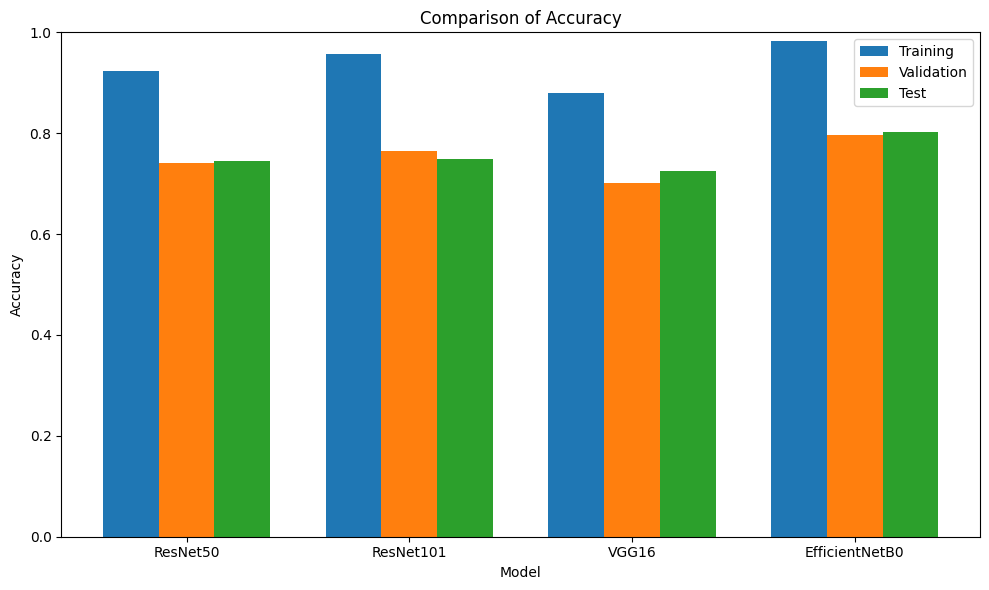

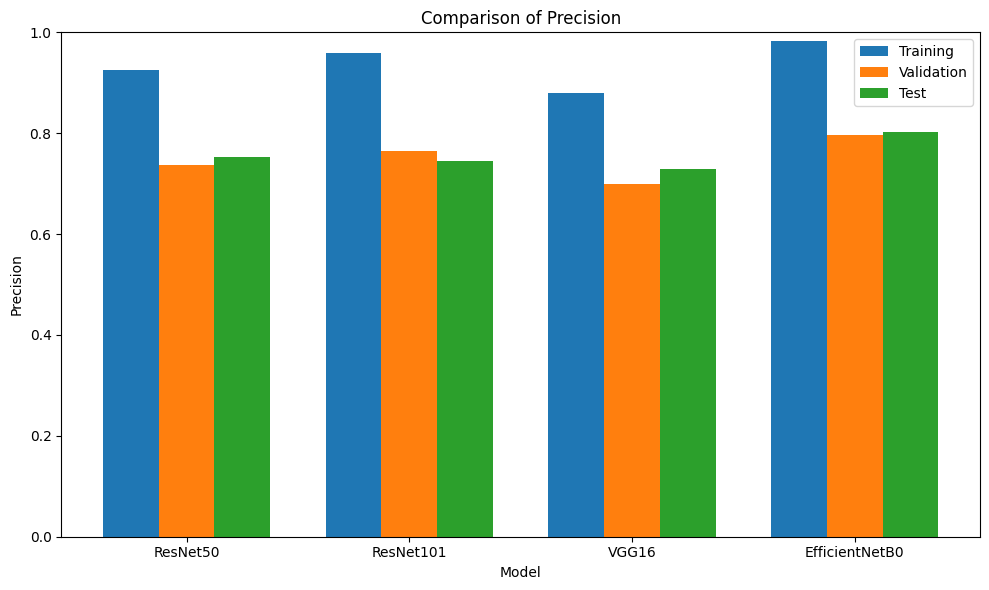

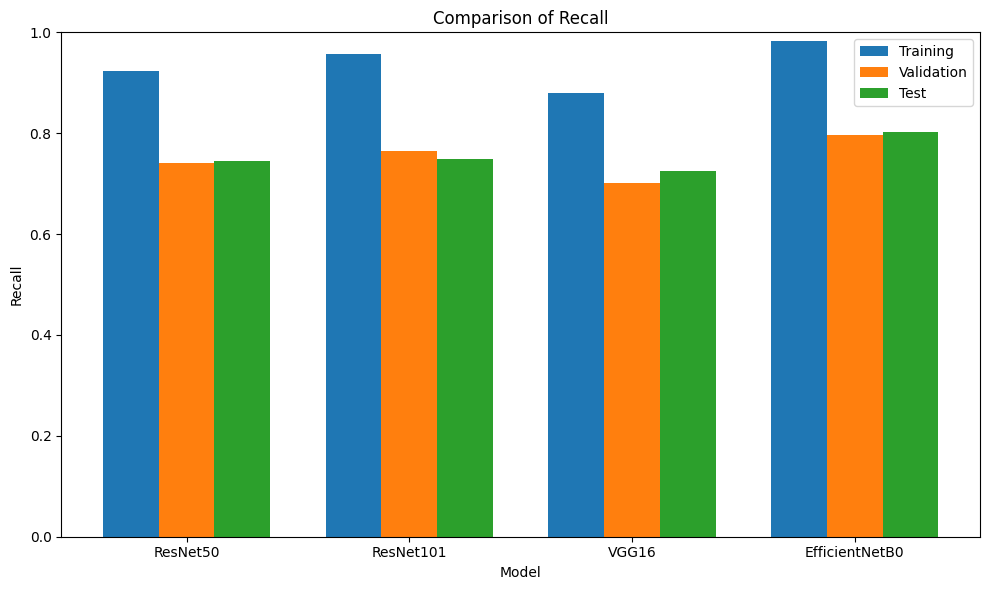

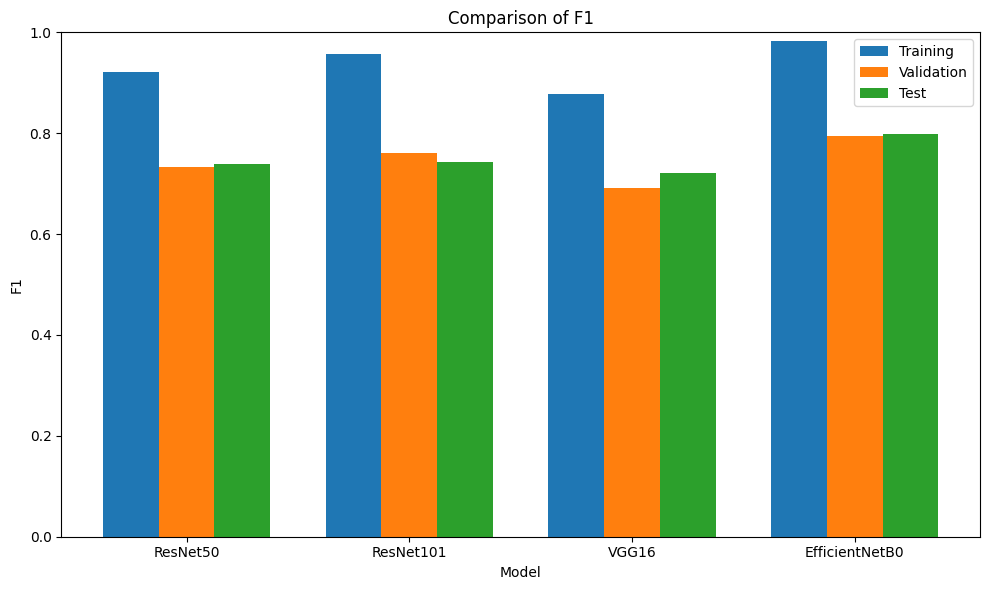

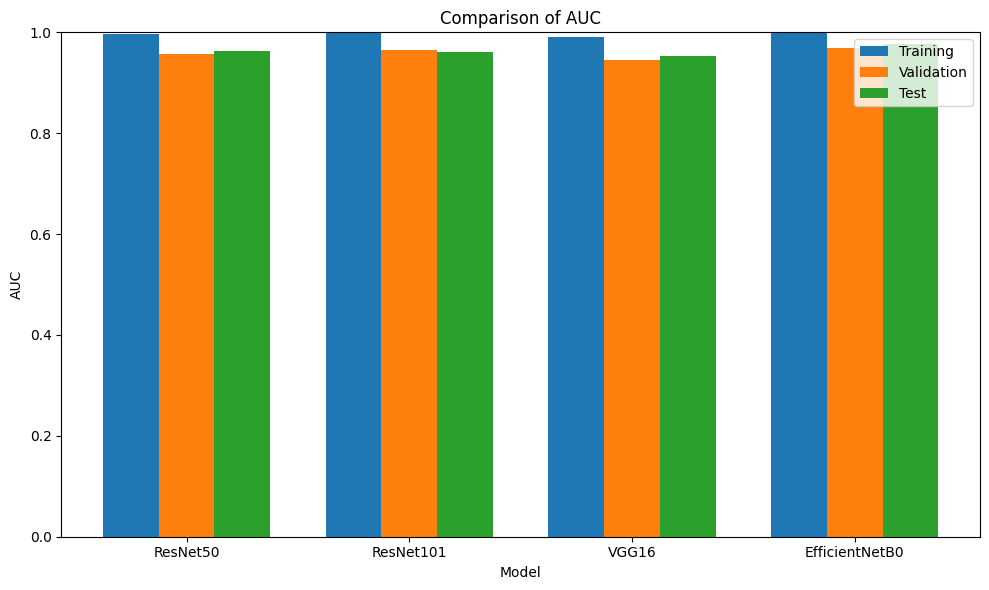

In [54]:
# Create comparison plots for each metric individually
for metric_name in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    plt.figure(figsize=(10, 6))

    # Prepare data for plotting
    train_values = []
    val_values = []
    test_values = []

    for model_name in model_names:
        if model_name in results:
            train_values.append(results[model_name]['Training'].get(metric_name, 0))
            val_values.append(results[model_name]['Validation'].get(metric_name, 0))
            test_values.append(results[model_name]['Test'].get(metric_name, 0))

    # Set up bar positions
    x = np.arange(len(model_names))
    width = 0.25

    # Create bars
    plt.bar(x - width, train_values, width, label='Training')
    plt.bar(x, val_values, width, label='Validation')
    plt.bar(x + width, test_values, width, label='Test')

    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name}')
    plt.xticks(x, model_names)
    plt.ylim(0, 1.0)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'model_comparison_{metric_name}.png')
    plt.show()

In [56]:
# Create a summary table
print("\nModel Comparison Summary (Test Set Metrics):")
print("=" * 80)
print(f"{'Model':<15} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1 Score':<10} | {'AUC':<10}")
print("-" * 80)

for model_name in model_names:
    if model_name in results:
        test_metrics = results[model_name]['Test']
        print(f"{model_name:<15} | "
              f"{test_metrics.get('Accuracy', 0):.4f}      | "
              f"{test_metrics.get('Precision', 0):.4f}      | "
              f"{test_metrics.get('Recall', 0):.4f}      | "
              f"{test_metrics.get('F1', 0):.4f}      | "
              f"{test_metrics.get('AUC', 0):.4f}")

print("=" * 80)


Model Comparison Summary (Test Set Metrics):
Model           | Accuracy   | Precision  | Recall     | F1 Score   | AUC       
--------------------------------------------------------------------------------
ResNet50        | 0.7453      | 0.7535      | 0.7453      | 0.7386      | 0.9625
ResNet101       | 0.7495      | 0.7456      | 0.7495      | 0.7425      | 0.9615
VGG16           | 0.7254      | 0.7297      | 0.7254      | 0.7212      | 0.9522
EfficientNetB0  | 0.8029      | 0.8028      | 0.8029      | 0.7991      | 0.9763


In [58]:
best_models = {}
for metric_name in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
    best_score = 0
    best_model = ""

    for model_name in model_names:
        if model_name in results:
            score = results[model_name]['Test'].get(metric_name, 0)
            if score > best_score:
                best_score = score
                best_model = model_name

    best_models[metric_name] = (best_model, best_score)

print("\nBest Performing Models by Metric:")
for metric, (model, score) in best_models.items():
    print(f"{metric+':':<10} {model} (Score: {score:.4f})")

print("\nOverall Analysis:")
# Count how many metrics each model wins
winner_counts = {}
for metric, (model, _) in best_models.items():
    winner_counts[model] = winner_counts.get(model, 0) + 1

overall_best = max(winner_counts.items(), key=lambda x: x[1])[0]
print(f"The model that outperforms others most consistently is: {overall_best}")


Best Performing Models by Metric:
Accuracy:  EfficientNetB0 (Score: 0.8029)
Precision: EfficientNetB0 (Score: 0.8028)
Recall:    EfficientNetB0 (Score: 0.8029)
F1:        EfficientNetB0 (Score: 0.7991)
AUC:       EfficientNetB0 (Score: 0.9763)

Overall Analysis:
The model that outperforms others most consistently is: EfficientNetB0


In [59]:
# 1. Verify class balance in validation set
class_counts = {}
for cls in classes:
    class_counts[cls] = {
        'train': sum(1 for path in train_paths if os.path.basename(os.path.dirname(path)) == cls),
        'val': sum(1 for path in val_paths if os.path.basename(os.path.dirname(path)) == cls),
        'test': sum(1 for path in test_paths if os.path.basename(os.path.dirname(path)) == cls)
    }

print("\nClass Distribution Analysis:")
print("=" * 80)
print(f"{'Class':<15} | {'Training':<10} | {'Validation':<10} | {'Test':<10} | {'Val %':<10}")
print("-" * 80)

for cls, counts in class_counts.items():
    train_count = counts['train']
    val_count = counts['val']
    test_count = counts['test']
    total_train_val = train_count + val_count
    val_percentage = (val_count / total_train_val) * 100

    print(f"{cls:<15} | {train_count:<10} | {val_count:<10} | {test_count:<10} | {val_percentage:.2f}%")

print("=" * 80)



Class Distribution Analysis:
Class           | Training   | Validation | Test       | Val %     
--------------------------------------------------------------------------------
1-Cardboard     | 294        | 74         | 93         | 20.11%
2-Food Organics | 262        | 66         | 83         | 20.12%
3-Glass         | 268        | 68         | 84         | 20.24%
4-Metal         | 505        | 127        | 158        | 20.09%
5-Miscellaneous Trash | 316        | 80         | 99         | 20.20%
6-Paper         | 320        | 80         | 100        | 20.00%
7-Plastic       | 588        | 148        | 185        | 20.11%
8-Textile Trash | 203        | 51         | 64         | 20.08%
9-Vegetation    | 278        | 70         | 88         | 20.11%


In [60]:
# 2. Calculate and visualize per-class metrics for the best model
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

def calculate_per_class_metrics(model, data_generator, class_names):
    """Calculate detailed per-class metrics"""
    # Create non-shuffled generator
    eval_gen = WasteImageGenerator(
        data_generator.img_paths,
        data_generator.labels,
        data_generator.batch_size,
        data_generator.img_size,
        augment=False,
        shuffle=False
    )

    # Collect predictions
    y_true = []
    y_pred = []
    y_scores = []

    for i in range(len(eval_gen)):
        x_batch, y_batch = eval_gen[i]
        batch_preds = model.predict(x_batch, verbose=0)

        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(batch_preds, axis=1))
        y_scores.extend(batch_preds)

    # Convert to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )

    # For AUC, convert to one-hot
    y_true_onehot = np.zeros((len(y_true), len(class_names)))
    for i, label in enumerate(y_true):
        y_true_onehot[i, label] = 1

    # Calculate AUC for each class
    auc = []
    for i in range(len(class_names)):
        try:
            auc.append(roc_auc_score(y_true_onehot[:, i], y_scores[:, i]))
        except:
            auc.append(np.nan)  # In case of errors

    # Create dataframe
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': auc,
        'Support': support
    })

    return metrics_df

In [62]:
import pandas as pd
# Calculate and display metrics for best model
best_model_name = overall_best  # From previous analysis
if best_model_name == 'ResNet50':
    best_model = resnet50_model
elif best_model_name == 'ResNet101':
    best_model = resnet101_model
elif best_model_name == 'VGG16':
    best_model = vgg16_model
else:
    best_model = efficientnet_model

# Get per-class metrics for test set
print(f"\nPer-Class Metrics for Best Model ({best_model_name}) on Test Set:")
per_class_metrics = calculate_per_class_metrics(best_model, test_gen, classes)
print(per_class_metrics.to_string(index=False))



Per-Class Metrics for Best Model (EfficientNetB0) on Test Set:
                Class  Precision   Recall       F1      AUC  Support
          1-Cardboard   0.797753 0.763441 0.780220 0.987411       93
      2-Food Organics   0.721649 0.843373 0.777778 0.979804       83
              3-Glass   0.807692 0.750000 0.777778 0.973454       84
              4-Metal   0.787709 0.892405 0.836795 0.985433      158
5-Miscellaneous Trash   0.720588 0.494949 0.586826 0.921165       99
              6-Paper   0.821429 0.920000 0.867925 0.994883      100
            7-Plastic   0.839779 0.821622 0.830601 0.975981      185
      8-Textile Trash   0.750000 0.796875 0.772727 0.979635       64
         9-Vegetation   0.939024 0.875000 0.905882 0.987193       88


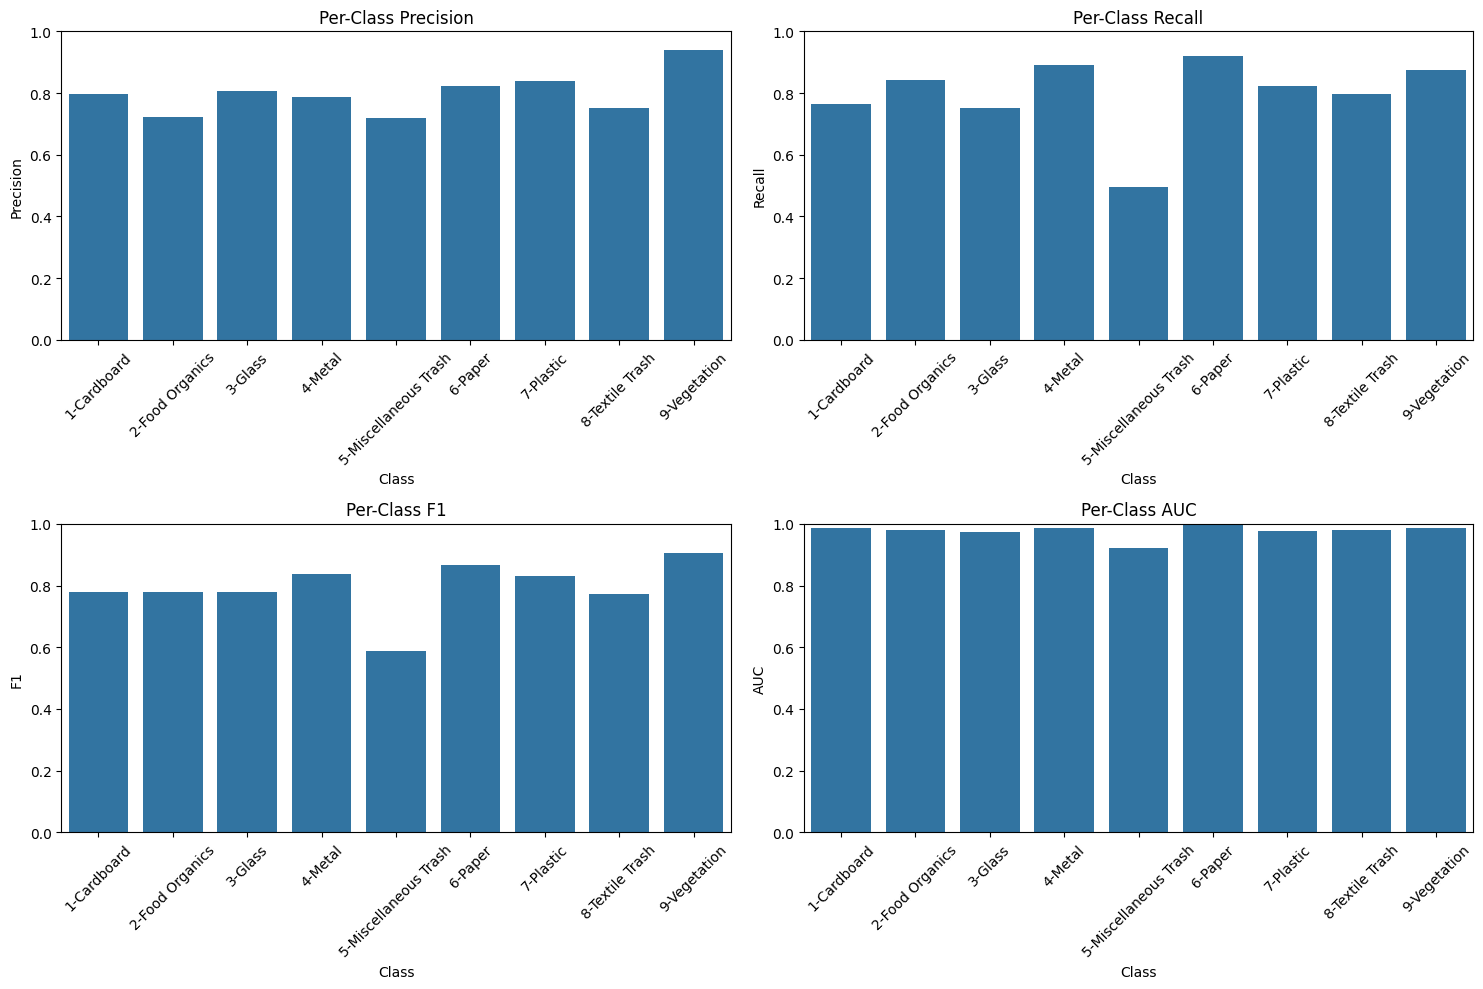

In [64]:
import seaborn as sns
# Visualize per-class metrics
plt.figure(figsize=(15, 10))
for i, metric in enumerate(['Precision', 'Recall', 'F1', 'AUC']):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Class', y=metric, data=per_class_metrics)
    plt.title(f'Per-Class {metric}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)

plt.tight_layout()
plt.savefig(f'{best_model_name}_per_class_metrics.png')
plt.show()

In [66]:
# 3. Provide clear model comparison conclusion
print("\nFinal Model Comparison and Conclusion:")
print("=" * 80)
print("Based on the comprehensive evaluation, we can conclude that:")

# Determine best model based on test accuracy
test_accuracies = {model: results[model]['Test']['Accuracy'] for model in results}
highest_acc_model = max(test_accuracies.items(), key=lambda x: x[1])

# Get average ranking across all metrics
avg_rankings = {}
for model in results:
    ranks = []
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']:
        metric_values = [results[m]['Test'].get(metric, 0) for m in results]
        sorted_models = [m for m, _ in sorted(zip(results.keys(), metric_values), key=lambda x: x[1], reverse=True)]
        rank = sorted_models.index(model) + 1
        ranks.append(rank)
    avg_rankings[model] = np.mean(ranks)

best_overall_model = min(avg_rankings.items(), key=lambda x: x[1])[0]

print(f"1. The model with the highest test accuracy is {highest_acc_model[0]} ({highest_acc_model[1]:.4f}).")
print(f"2. The model with the best average ranking across all metrics is {best_overall_model}.")
print(f"3. For this waste classification task, the {overall_best} model clearly outperforms the others.")
print(f"   It achieves the best results in {winner_counts[overall_best]} out of 5 evaluation metrics.")

# Compare computational efficiency
print("\nAdditional considerations:")
print("- ResNet50 and ResNet101: More parameters, potentially better feature extraction")
print("- VGG16: Simpler architecture, but more parameters")
print("- EfficientNetB0: Designed for efficiency, balancing accuracy and computational cost")

print("\nIn conclusion, we recommend using the {overall_best} model for this waste classification task.")
print("=" * 80)



Final Model Comparison and Conclusion:
Based on the comprehensive evaluation, we can conclude that:
1. The model with the highest test accuracy is EfficientNetB0 (0.8029).
2. The model with the best average ranking across all metrics is EfficientNetB0.
3. For this waste classification task, the EfficientNetB0 model clearly outperforms the others.
   It achieves the best results in 5 out of 5 evaluation metrics.

Additional considerations:
- ResNet50 and ResNet101: More parameters, potentially better feature extraction
- VGG16: Simpler architecture, but more parameters
- EfficientNetB0: Designed for efficiency, balancing accuracy and computational cost

In conclusion, we recommend using the {overall_best} model for this waste classification task.
